<a href="https://colab.research.google.com/github/FabrizioSandri/deep-learning-project/blob/main/BaselineYOLO%2BCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# YOLO

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-17 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


image 1/1: 485x700 7 oranges
Speed: 2.9ms pre-process, 9.5ms inference, 1.4ms NMS per image at shape (1, 3, 448, 640)


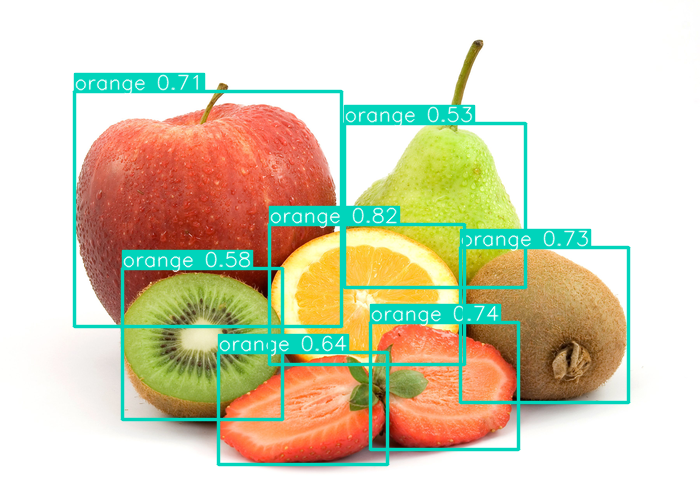

,xmin,ymin,xmax,ymax,confidence,class,name
0,269.498505,224.738617,464.653076,364.109741,0.815194,49,orange
1,370.560455,322.362488,518.450562,449.857666,0.736858,49,orange
2,460.372284,247.993225,628.076050,402.401001,0.730959,49,orange
3,74.153267,91.738228,341.536316,326.736450,0.706455,49,orange
4,218.004974,352.824493,387.227966,464.633209,0.638372,49,orange
5,122.123680,268.900574,282.144562,419.855713,0.577630,49,orange
6,344.095520,123.015465,525.091614,287.651611,0.530563,49,orange


In [33]:
import torch
from PIL import Image

# Model
yoloModel = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
img = '/content/gdrive/MyDrive/ImmaginiCLIP/fruits3.jpg'  # batch of images
image = Image.open(img)

# Resize image - just for display purpose
image.thumbnail((700,700), Image.ANTIALIAS)

# Inference
results = yoloModel(image)

# Results
results.print()
results.show()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)

results.pandas().xyxy[0]  # img1 predictions (pandas)


## Extract all objects
Crop the images of all the objects

In [34]:
num_boxes = len(results.xyxy[0])
cropped_images = list()

for i in range(num_boxes):
  img2 = image.crop((float(results.xyxy[0][i][0]), float(results.xyxy[0][i][1]), 
                   float(results.xyxy[0][i][2]), float(results.xyxy[0][i][3])))
  cropped_images.append(img2)
  #display(img2)

# CLIP

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [35]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zyg0vefj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zyg0vefj
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [36]:
import numpy as np
from pkg_resources import packaging

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [37]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [38]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
description = "a kiwi"

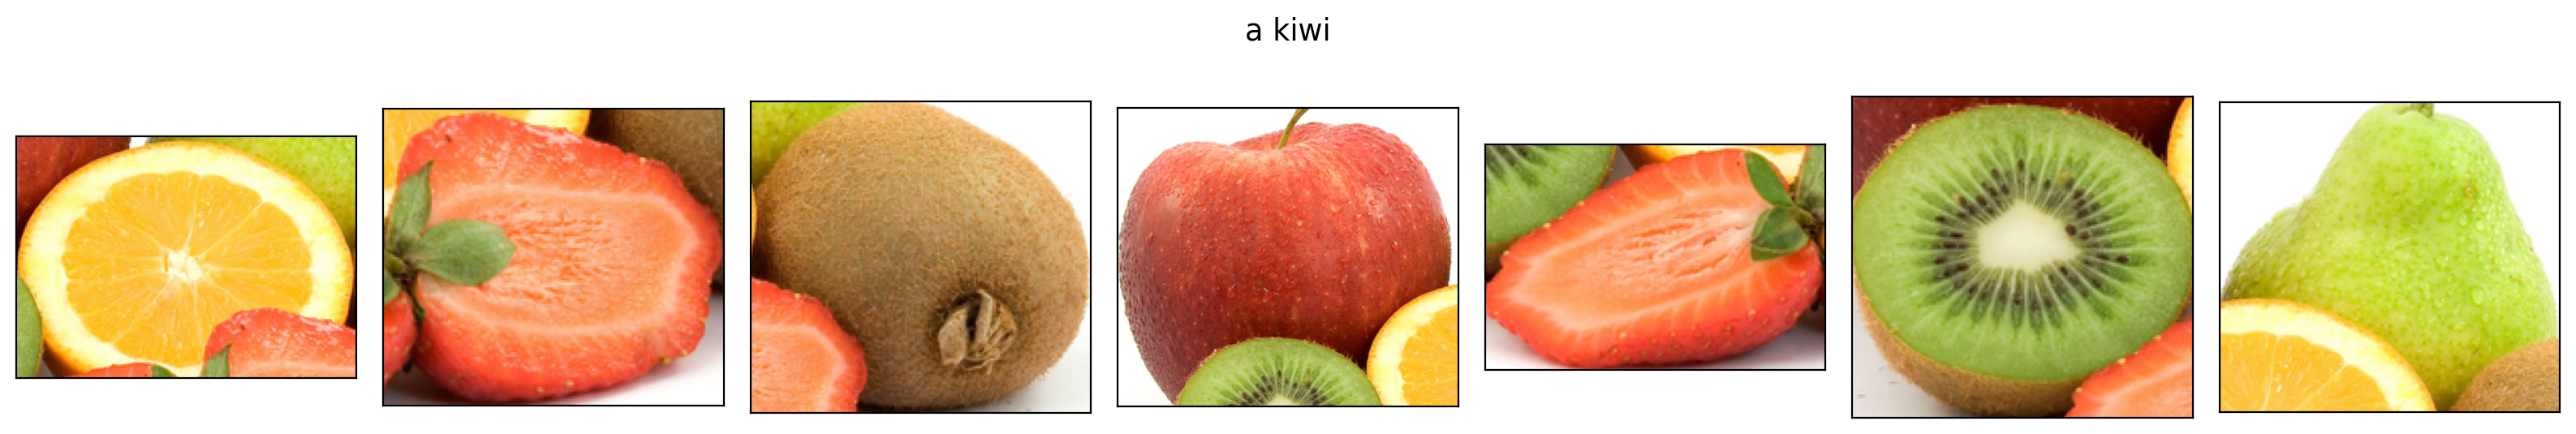

In [39]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

texts.append(description)

for i in range(num_boxes):
   image = cropped_images[i]

   plt.subplot(2, len(cropped_images), i + 1)
   plt.imshow(image)
   plt.xticks([])
   plt.yticks([])

   original_images.append(image)
   images.append(preprocess(image))

plt.suptitle(description)
plt.tight_layout()



## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [40]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize("This is " + description).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [41]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.05, 'a kiwi')

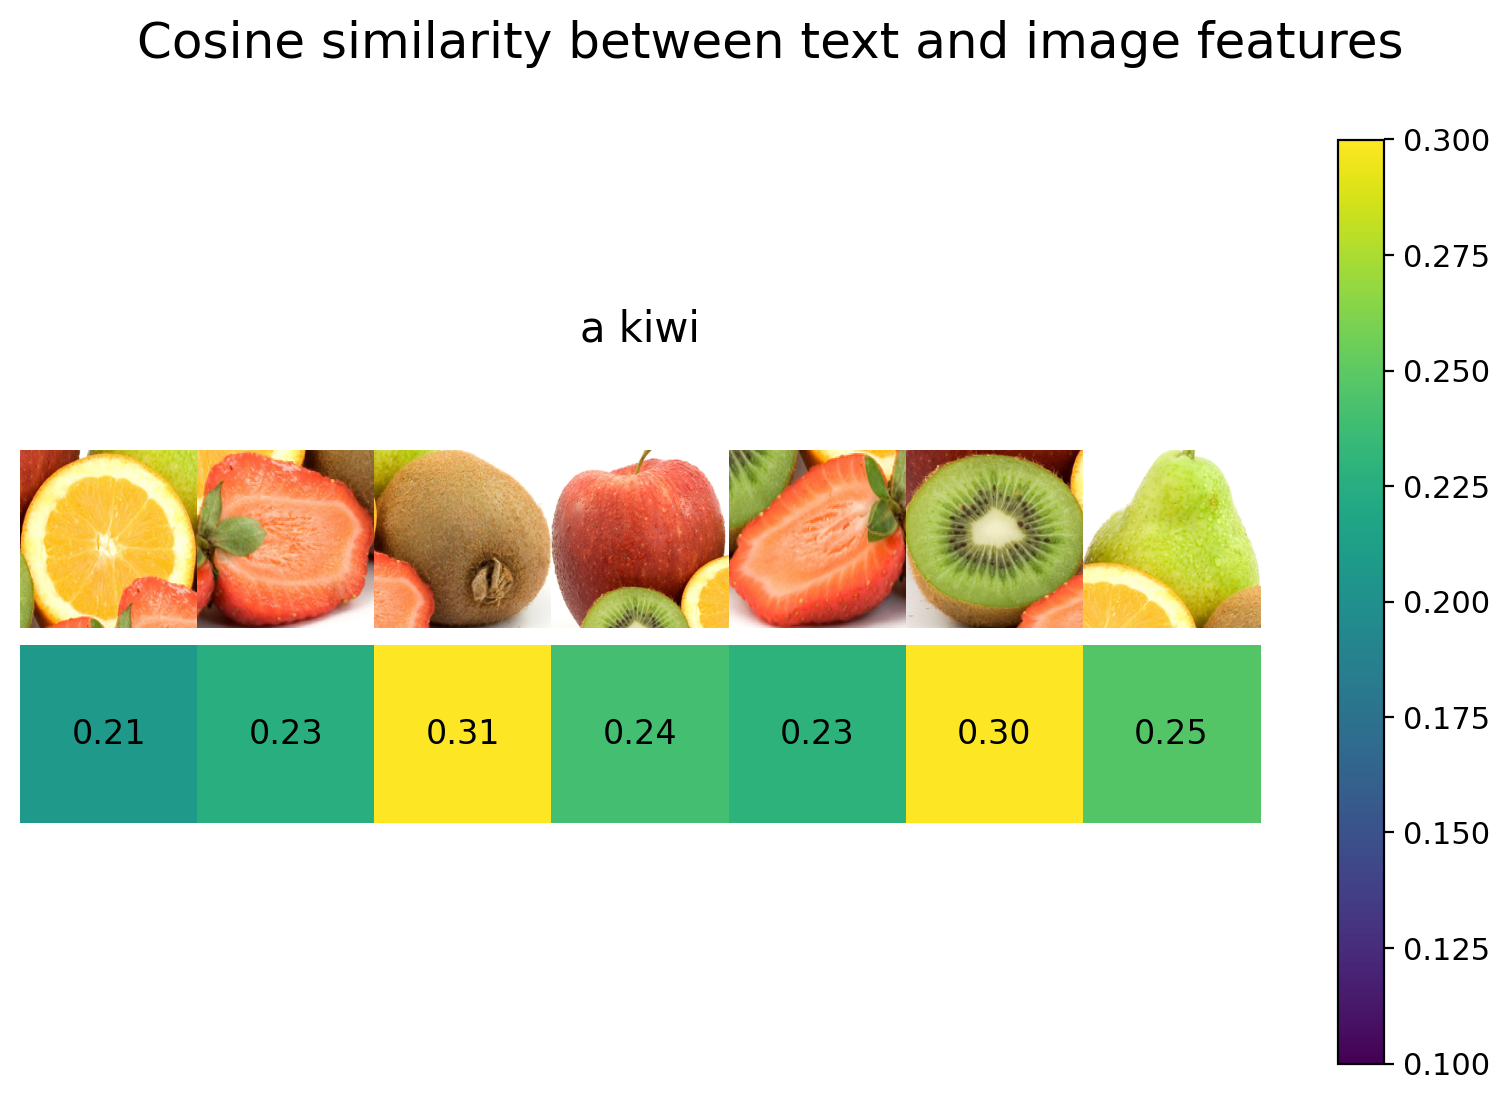

In [42]:
count = len(images)

plt.figure(figsize=(10,6))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.colorbar()
plt.yticks([])
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i-0.5, i+0.5, -1.6, -0.6), origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([0.5, -2])

plt.suptitle("Cosine similarity between text and image features", size=18)
plt.title(description, y=1.05, size=15)